## DEMENT in parallel

In [1]:
#..Load modules
import os
import sys
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
from initialization import initialize_data
from grid import Grid
from output import Output
from utility import export

In [3]:
input_folder  = "input"   # input folder name
#...Set up the working directory
os.chdir(input_folder)

In [4]:
import joblib
from joblib import Parallel, delayed

In [6]:
def dement(outname, random_seed):
    #outname_t[i]  = "20220221" + str(int(i))    # output file name and seed of Pseudo-RNG + "20220211"
    input_folder  = "input"   # input folder name 
    output_folder = "output"  # output folder name
    #outname       = outname_t[i]
    #outname       = "20220131"   # output file name and seed of Pseudo-RNG
    #...Set up the working directory
    #  os.chdir(input_folder)
    #...seed the pseudorandom number generator
    np.random.seed(random_seed)

    #...a few system constants
    runtime    = pd.read_csv('runtime_cellulose.txt',header=None,index_col=0,sep='\t')
    pulse      = int(runtime.loc['pulse',1])         # number of pulses
    cycle      = int(runtime.loc['end_time',1])      # number of time steps in each pulse
    interval   = int(runtime.loc['interval',1])      # interval of time step to record outputs
    mic_reinit = True    # indicate reinitialization of microbial community

    #...Initialize data by calling the Function: Initialize_Data()
    data_initialization = initialize_data(runtime)

    #...Prepare for output by creating an instance of the Output class
    Output_init = Output(runtime,data_initialization)

    #...Create an instance of the Grid class
    Ecosystem = Grid(runtime,data_initialization)

    #...Run the model
    for p in range(pulse):
    
        for i in range(p*cycle, (p+1)*cycle):
    
            # substrates degradation
            Ecosystem.degradation(p,i)

            # monomers uptake
            Ecosystem.uptake(p,i)

            # microbial metabolism
            Ecosystem.metabolism(i)

            # microbial death
            Ecosystem.mortality(i)

            # microbial reproduction and dispersal
            Ecosystem.reproduction(i)
    
            # output data using the "output" method in the Output class
            if i == 0:
                Output_init.output(Ecosystem,i)  # day 1
            elif i%interval==interval-1:
                Output_init.output(Ecosystem,i)  # interval
        
            # if only 1 pusle, skip all following lines within this loop
            #if pulse == 1:
            #    continue

            # output microbial mass of every iteration using the "microbes_df" method in the Output class
            Output_init.microbes_abundance(Ecosystem,i)

            # re-initialize microbial community in each new pulse
            if i == (p+1)*cycle-1:
                Ecosystem.repopulation(Output_init,i,mic_reinit)

    return Output_init

results = Parallel(n_jobs=4)(delayed(dement)("20220221" + str(int(i)),i) for i in range(4))

## Saving the model output

In [7]:
import pickle
output = open('C:/luciana_datos/UCI/Project_14 (Anna)/DEMENT_gradcatch/DEMENT/SP01/output/results_dement.pkl', 'wb')
pickle.dump(results, output)
output.close()

## Open the pickle output

In [8]:
#import pprint
pkl_file = open('C:/luciana_datos/UCI/Project_14 (Anna)/DEMENT_gradcatch/DEMENT/SP01/output/results_dement.pkl', 'rb')
test     = pickle.load(pkl_file)
pkl_file.close()

## Test Plots

In [9]:
tt        = np.linspace(0,3,4) # Number of repetitions = 4
time      = np.linspace(0,100,100+1)

### Respiration

In [10]:
respi_base     = []

for i in tt:
        respi_base.append(test[int(i)].RespSeries)

Respi_mean = (np.array(respi_base).mean(axis=0))
respiration_5  = np.percentile(respi_base,5,axis=0)
respiration_95 = np.percentile(respi_base,95,axis=0)

C:\Users\lucia\AppData\Local\Temp\ipykernel_17648\187784392.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


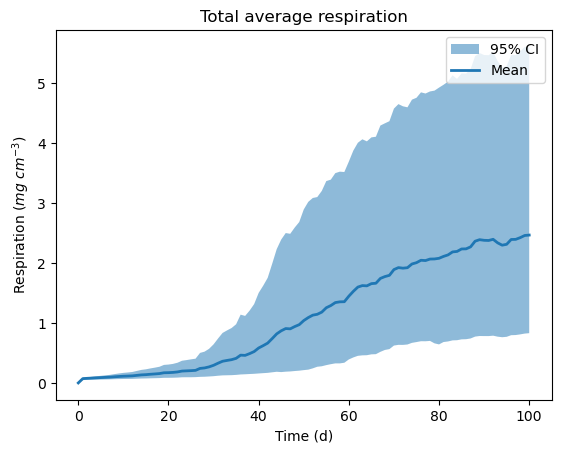

In [10]:
fig, ax = plt.subplots()

ax.fill_between(time,respiration_5,respiration_95, alpha=.5, linewidth=0,label="95% CI")
ax.plot(time,Respi_mean, linewidth=2,label="Mean")

plt.xlabel('Time (d)') 
plt.ylabel('Respiration ($mg$ $cm^{-3}$)') 
plt.title('Total average respiration') 
ax.legend()
fig.show()

C:\Users\lucia\AppData\Local\Temp\ipykernel_19092\187784392.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


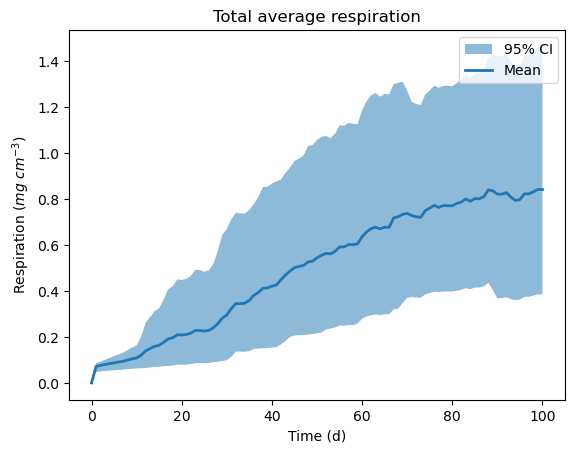

In [11]:
fig, ax = plt.subplots()

ax.fill_between(time,respiration_5,respiration_95, alpha=.5, linewidth=0,label="95% CI")
ax.plot(time,Respi_mean, linewidth=2,label="Mean")

plt.xlabel('Time (d)') 
plt.ylabel('Respiration ($mg$ $cm^{-3}$)') 
plt.title('Total average respiration') 
ax.legend()
fig.show()

In [20]:
test[int(0)].MicrobesSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
Tax1,2.0,1.976186,1.956965,1.941824,1.930671,1.923228,1.919378,1.918944,1.922583,1.930017,...,5.312965,5.304399,5.295867,5.287384,5.279060,5.271022,5.263109,5.255371,5.247816,5.240370
Tax2,2.0,1.991774,1.984359,1.977747,1.971993,1.966995,1.962737,1.959187,1.956471,1.954529,...,2.752609,2.755160,2.757486,2.759610,2.761591,2.763485,2.765221,2.766822,2.768292,2.769604
Tax3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax4,1.0,0.980202,0.973114,0.977216,0.992125,1.017190,1.052140,1.096703,1.152170,1.218237,...,8.459824,8.432818,8.405973,8.379350,8.353206,8.327840,8.302868,8.278408,8.254482,8.230895
Tax5,2.0,1.979979,1.968078,1.963736,1.966428,1.975540,1.990669,2.011336,2.038179,2.070553,...,4.723393,4.716053,4.708736,4.701460,4.694295,4.687322,4.680439,4.673676,4.667040,4.660480
Tax6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax8,2.0,1.986995,1.975742,1.966146,1.958248,1.952005,1.947422,1.944472,1.943450,1.944273,...,4.002096,4.000389,3.998012,3.995117,3.992226,3.989218,3.985906,3.982635,3.979407,3.976201
Tax9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax10,2.0,1.991211,1.983229,1.976087,1.969803,1.964375,1.959822,1.956145,1.953497,1.951848,...,3.284101,3.286668,3.288908,3.290850,3.292550,3.294058,3.295329,3.296391,3.297255,3.297909


In [12]:
test[int(0)].MicrobesSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
Tax1,2.0,1.976186,1.956534,1.940597,1.928300,1.919392,1.913762,1.911242,1.912410,1.916986,...,1.148656,1.147442,1.146207,1.144961,1.143746,1.142610,1.141493,1.140415,1.139380,1.138357
Tax2,2.0,1.991774,1.984331,1.977609,1.971611,1.966301,1.961666,1.957679,1.954456,1.951942,...,2.570510,2.567898,2.565288,2.562682,2.560083,2.557499,2.554920,2.552349,2.549787,2.547228
Tax3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax4,1.0,0.980202,0.973064,0.977236,0.992202,1.017270,1.052095,1.095904,1.150948,1.216337,...,0.980200,0.978970,0.977731,0.976494,0.975303,0.974209,0.973149,0.972141,0.971191,0.970265
Tax5,2.0,1.979979,1.967985,1.963152,1.965138,1.973357,1.987417,2.006676,2.032195,2.063131,...,2.265434,2.261721,2.258006,2.254296,2.250626,2.247035,2.243473,2.239956,2.236486,2.233038
Tax6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax8,2.0,1.986995,1.975572,1.965655,1.957290,1.950447,1.945134,1.941329,1.939304,1.938979,...,2.546400,2.544666,2.542926,2.541186,2.539472,2.537814,2.536173,2.534560,2.532978,2.531405
Tax9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tax10,2.0,1.991211,1.983170,1.975867,1.969347,1.963616,1.958694,1.954587,1.951437,1.949216,...,2.629031,2.627714,2.626394,2.625074,2.623769,2.622497,2.621235,2.619988,2.618758,2.617533


In [30]:
test[int(3)].SubstratesSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
DeadMic,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.939327,1.933768,1.928535,1.923590,1.918842,1.914206,1.909769,1.905493,1.901365,1.897417
DeadEnz,0.0,0.0,0.000194,0.000571,0.001121,0.001834,0.002702,0.003717,0.004870,0.006154,...,0.328687,0.332920,0.337170,0.341417,0.345586,0.349594,0.353543,0.357398,0.361153,0.364857
Cellulose,14689.0,14689.0,14688.972637,14688.921479,14688.847285,14688.752160,14688.637223,14688.504037,14688.348742,14688.173803,...,14612.185734,14610.484003,14608.830575,14607.213435,14605.591371,14603.917794,14602.247852,14600.562747,14598.857762,14597.159562


In [13]:
test[int(3)].SubstratesSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
DeadMic,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.258016,1.252656,1.247613,1.242850,1.238284,1.233836,1.229583,1.225491,1.221546,1.217778
DeadEnz,0.0,0.0,0.000194,0.000571,0.001120,0.001832,0.002698,0.003709,0.004857,0.006135,...,0.226091,0.228088,0.230084,0.232069,0.234008,0.235859,0.237675,0.239441,0.241152,0.242836
Cellulose,14689.0,14689.0,14688.972641,14688.921513,14688.847411,14688.752469,14688.637837,14688.505102,14688.350452,14688.176374,...,14638.558978,14637.716326,14636.904691,14636.117543,14635.334427,14634.532803,14633.739022,14632.943944,14632.145228,14631.355187


In [31]:
test[int(0)].MonomersSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
NH4,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PO4,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DeadMic,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.064778,0.064416,0.063867,0.063162,0.062329,0.061386,0.060348,0.059229,0.058043,0.056805
DeadEnz,0.0,0.0,0.000000,3.348355e-08,1.789337e-07,5.531939e-07,0.000001,0.000003,0.000005,0.000007,...,0.004969,0.005059,0.005186,0.005340,0.005482,0.005573,0.005668,0.005750,0.005818,0.005897
Mon3,0.0,0.0,0.016497,4.720433e-02,9.122017e-02,1.471546e-01,0.213918,0.290245,0.377072,0.472671,...,27.262329,27.703449,28.129247,28.540520,28.941414,29.335537,29.718086,30.090298,30.452138,30.802223


In [14]:
test[int(0)].MonomersSeries

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
NH4,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PO4,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DeadMic,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.154542,0.156273,0.157671,0.158772,0.159625,0.160267,0.160684,0.160899,0.160925,0.160768
DeadEnz,0.0,0.0,0.000000,4.060776e-08,2.159501e-07,6.642724e-07,0.000002,0.000003,0.000005,0.000009,...,0.015473,0.015702,0.015932,0.016161,0.016378,0.016573,0.016759,0.016934,0.017096,0.017253
Mon3,0.0,0.0,0.017871,5.138307e-02,9.949798e-02,1.605759e-01,0.233526,0.317897,0.412920,0.517814,...,23.824359,24.118112,24.394543,24.656606,24.912806,25.172002,25.423618,25.671241,25.915681,26.152299


In [34]:
test[int(0)].MonomersSeries.T["Mon3"]

0       0.000000
1       0.000000
2       0.016497
3       0.047204
4       0.091220
         ...    
96     29.335537
97     29.718086
98     30.090298
99     30.452138
100    30.802223
Name: Mon3, Length: 101, dtype: float64

In [15]:
test[int(0)].MonomersSeries.T["Mon3"]

0       0.000000
1       0.000000
2       0.017871
3       0.051383
4       0.099498
         ...    
96     25.172002
97     25.423618
98     25.671241
99     25.915681
100    26.152299
Name: Mon3, Length: 101, dtype: float64

In [5]:
    parameters      = pd.read_csv('parameters_cellulose.csv',         header=None, index_col=0).astype('float32')   # parameters
    substrates_init = pd.read_csv('initial_substrates_cellulose.csv', header=0,    index_col=0).astype('float32')   # initial substrates
    sub_mon_input   = pd.read_csv('sub_mon_inputs_cellulose.csv',     header=0,    index_col=0).astype('float32')   # inputs of substrates and monomers
    Ea_input        = pd.read_csv("enzyme_ea_cellulose.csv",          header=0,    index_col=0).astype('float32')   # enzyme activation energy
    climate         = pd.read_csv('climate_SP1.csv',            header=0,    index_col=0)                     # climate forcings

In [10]:
    runtime    = pd.read_csv('runtime_cellulose.txt',header=None,index_col=0,sep='\t')
    pulse      = int(runtime.loc['pulse',1])         # number of pulses
    cycle      = int(runtime.loc['end_time',1])      # number of time steps in each pulse
    interval   = int(runtime.loc['interval',1])      # interval of time step to record outputs

In [11]:
data_initialization = initialize_data(runtime)

C:\luciana_datos\UCI\Project_14 (Anna)\DEMENT_gradcatch\DEMENT\SP01\microbe.py:131: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.500000165568462' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
C:\luciana_datos\UCI\Project_14 (Anna)\DEMENT_gradcatch\DEMENT\SP01\microbe.py:132: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.2777777789275588' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.


Before placement-- Bac_taxa= 100 Fun_taxa= 0
After placement-- Bac_taxa= 100 Fun_taxa= 0
After placement-- Bac_density= 0.9828 Fun_density= 0.0


Do not forget that the initial concentration of the substrate is indeed a concentration. It is somehow summed up and to calculate final concentration and the end, we need to divide by the gridsize. The same has to be done for the other variables as they are always added up for the whole grid even though the units are concentration.

In [29]:
np.sum(data_initialization["Substrates"].T["Cellulose"].T["C"])/10000

7.09999921875